<a href="https://colab.research.google.com/github/fazmila/Project/blob/main/PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install Kaggle API if not already installed
!pip install kaggle --upgrade --quiet

# Move the kaggle.json file to the appropriate directory (this step may vary depending on your environment)
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"  # Change '/content' if needed

# Download the dataset from Kaggle
!kaggle datasets download -d rikdifos/credit-card-approval-prediction --unzip

Dataset URL: https://www.kaggle.com/datasets/rikdifos/credit-card-approval-prediction
License(s): CC0-1.0
  0% 0.00/5.32M [00:00<?, ?B/s]
100% 5.32M/5.32M [00:00<00:00, 79.6MB/s]


In [42]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [3]:
# Load the datasets
application_df = pd.read_csv("application_record.csv")
credit_df = pd.read_csv("credit_record.csv")

In [4]:
print(application_df)


             ID CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
0       5008804           M            Y               Y             0   
1       5008805           M            Y               Y             0   
2       5008806           M            Y               Y             0   
3       5008808           F            N               Y             0   
4       5008809           F            N               Y             0   
...         ...         ...          ...             ...           ...   
438552  6840104           M            N               Y             0   
438553  6840222           F            N               N             0   
438554  6841878           F            N               N             0   
438555  6842765           F            N               Y             0   
438556  6842885           F            N               Y             0   

        AMT_INCOME_TOTAL      NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0               427500.0      

In [5]:
print(credit_df)

              ID  MONTHS_BALANCE STATUS
0        5001711               0      X
1        5001711              -1      0
2        5001711              -2      0
3        5001711              -3      0
4        5001712               0      C
...          ...             ...    ...
1048570  5150487             -25      C
1048571  5150487             -26      C
1048572  5150487             -27      C
1048573  5150487             -28      C
1048574  5150487             -29      C

[1048575 rows x 3 columns]


In [6]:
# Display the first few rows of each dataset
print("Application Data:")
print(application_df.head())
print("\nCredit Data:")
print(credit_df.head())

Application Data:
        ID CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
0  5008804           M            Y               Y             0   
1  5008805           M            Y               Y             0   
2  5008806           M            Y               Y             0   
3  5008808           F            N               Y             0   
4  5008809           F            N               Y             0   

   AMT_INCOME_TOTAL      NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0          427500.0               Working               Higher education   
1          427500.0               Working               Higher education   
2          112500.0               Working  Secondary / secondary special   
3          270000.0  Commercial associate  Secondary / secondary special   
4          270000.0  Commercial associate  Secondary / secondary special   

     NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  DAYS_BIRTH  DAYS_EMPLOYED  \
0        Civil marriage   Rented apar

In [7]:
# Step 1: Preprocess Application Data
# Drop duplicates based on 'ID' if there are any
application_df = application_df.drop_duplicates(subset="ID")

In [8]:
# Handle missing values in the application dataset
application_df = application_df.fillna(method='ffill')

<ipython-input-8-6de676ad27e6>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  application_df = application_df.fillna(method='ffill')


In [11]:
# Encode categorical variables in the application dataset
le = LabelEncoder()
for column in application_df.select_dtypes(include=['object']).columns:
    application_df[column] = le.fit_transform(application_df[column])

In [12]:
# Feature Engineering on Application Data
# 1: Age from 'DAYS_BIRTH'
application_df['AGE_YEARS'] = (-application_df['DAYS_BIRTH'] / 365).astype(int)

# 2: Years employed from 'DAYS_EMPLOYED'
application_df['YEARS_EMPLOYED'] = (-application_df['DAYS_EMPLOYED'] / 365).replace({365243: np.nan}).astype(float)

# 3: Credit product ownership by occupation type (hypothetical example)
application_df['OWN_CAR_REALTY'] = application_df['FLAG_OWN_CAR'] + application_df['FLAG_OWN_REALTY']

# 4: Deriving ratios, e.g., income to number of family members
application_df['INCOME_PER_PERSON'] = application_df['AMT_INCOME_TOTAL'] / application_df['CNT_FAM_MEMBERS'].replace(0, 1)

# Drop original 'DAYS_BIRTH' and 'DAYS_EMPLOYED' columns after creating derived features
application_df = application_df.drop(['DAYS_BIRTH', 'DAYS_EMPLOYED'], axis=1)


In [17]:
# Step 2: Preprocess Credit Data

# Convert everything to string format to handle mixed data types
credit_df['STATUS'] = credit_df['STATUS'].astype(str)

# Check unique values in 'STATUS' to confirm
print("Unique values in STATUS column before replacement:", credit_df['STATUS'].unique())

Unique values in STATUS column before replacement: ['-1' '0' 'C' '1' '2' '3' '4' '5']


In [18]:
# Replace known string values with integers, handling 'C' and 'X' as -1
credit_df['STATUS'] = credit_df['STATUS'].replace({
    "-1": -1,  # Already represented as '-1'
    "0": 0, "1": 1, "2": 2, "3": 3, "4": 4, "5": 5,
    "C": -1,   # Treat 'C' as closed/no recent status
    "X": -1    # Treat 'X' as no payment history
})

<ipython-input-18-99e7f806a5f4>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  credit_df['STATUS'] = credit_df['STATUS'].replace({


In [19]:
# Convert the 'STATUS' column to integer after replacement
credit_df['STATUS'] = credit_df['STATUS'].astype(int)

# Confirm the final state of the 'STATUS' column
print("Unique values in STATUS column after processing:", credit_df['STATUS'].unique())

Unique values in STATUS column after processing: [-1  0  1  2  3  4  5]


In [20]:
# Continue with feature engineering on Credit Data
credit_df_agg = credit_df.groupby("ID").agg({
    "STATUS": "max",           # Highest status to see if the person had serious delinquencies
    "MONTHS_BALANCE": "count"  # Count of months with credit data available
}).reset_index()

In [21]:
# Rename aggregated columns for clarity
credit_df_agg = credit_df_agg.rename(columns={"STATUS": "MAX_CREDIT_STATUS", "MONTHS_BALANCE": "CREDIT_MONTH_COUNT"})

In [24]:
# Step 3: Merge the Datasets on 'ID'
merged_df = pd.merge(application_df, credit_df_agg, on="ID", how="inner")
print(merged_df)

            ID  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
0      5008804            1             1                1             0   
1      5008805            1             1                1             0   
2      5008806            1             1                1             0   
3      5008808            0             0                1             0   
4      5008809            0             0                1             0   
...        ...          ...           ...              ...           ...   
36452  5149828            1             1                1             0   
36453  5149834            0             0                1             0   
36454  5149838            0             0                1             0   
36455  5150049            0             0                1             0   
36456  5150337            1             0                1             0   

       AMT_INCOME_TOTAL  NAME_INCOME_TYPE  NAME_EDUCATION_TYPE  \
0              427500

In [25]:
# Step 4: Additional Feature Engineering on Merged Data
# 1: Flag for risky credit history (e.g., status above 2)
merged_df['RISKY_CREDIT_HISTORY'] = merged_df['MAX_CREDIT_STATUS'].apply(lambda x: 1 if x >= 3 else 0)

# 2: Ratio of income to credit months (proxy for stability)
merged_df['INCOME_PER_CREDIT_MONTH'] = merged_df['AMT_INCOME_TOTAL'] / merged_df['CREDIT_MONTH_COUNT'].replace(0, 1)

# 3: Employment stability feature (years employed vs age)
merged_df['EMPLOYMENT_AGE_RATIO'] = merged_df['YEARS_EMPLOYED'] / merged_df['AGE_YEARS'].replace(0, 1)

# 4: Deriving a family size feature based on CNT_FAM_MEMBERS
merged_df['FAMILY_SIZE'] = merged_df['CNT_FAM_MEMBERS']

# 5: Credit history stability (max status over months)
merged_df['CREDIT_HISTORY_STABILITY'] = merged_df['CREDIT_MONTH_COUNT'] / (merged_df['YEARS_EMPLOYED'] + 1)

# 6: Combining car and realty ownership for more insight
merged_df['OWN_CAR_REALTY'] = merged_df['FLAG_OWN_CAR'] + merged_df['FLAG_OWN_REALTY']

In [26]:
# Final Cleanup
# Fill any remaining NaN values (this is optional depending on model requirements)
merged_df = merged_df.fillna(0)

In [27]:
# Final Feature Selection
# You can select the most important features for model building
# For example, removing the original 'ID' column after merging
merged_df = merged_df.drop(['ID'], axis=1)

In [28]:
# Display the final merged and engineered dataset
print("Final Merged Data Shape:", merged_df.shape)
print(merged_df.head())

Final Merged Data Shape: (36457, 26)
   CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  \
0            1             1                1             0          427500.0   
1            1             1                1             0          427500.0   
2            1             1                1             0          112500.0   
3            0             0                1             0          270000.0   
4            0             0                1             0          270000.0   

   NAME_INCOME_TYPE  NAME_EDUCATION_TYPE  NAME_FAMILY_STATUS  \
0                 4                    1                   0   
1                 4                    1                   0   
2                 4                    4                   1   
3                 0                    4                   3   
4                 0                    4                   3   

   NAME_HOUSING_TYPE  FLAG_MOBIL  ...  YEARS_EMPLOYED  OWN_CAR_REALTY  \
0                 

**EDA**

In [30]:
# Step 1: Exploratory Data Analysis (EDA)
# Show basic statistics of the merged data
print("Descriptive Statistics of Merged Data:")
print(merged_df.describe())

Descriptive Statistics of Merged Data:
        CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
count  36457.000000  36457.000000     36457.000000  36457.000000   
mean       0.329895      0.379708         0.672189      0.430315   
std        0.470181      0.485321         0.469422      0.742367   
min        0.000000      0.000000         0.000000      0.000000   
25%        0.000000      0.000000         0.000000      0.000000   
50%        0.000000      0.000000         1.000000      0.000000   
75%        1.000000      1.000000         1.000000      1.000000   
max        1.000000      1.000000         1.000000     19.000000   

       AMT_INCOME_TOTAL  NAME_INCOME_TYPE  NAME_EDUCATION_TYPE  \
count      3.645700e+04      36457.000000         36457.000000   
mean       1.866857e+05          2.398195             3.097183   
std        1.017892e+05          1.734032             1.341292   
min        2.700000e+04          0.000000             0.000000   
25%        1.21500

In [31]:
# Check for class imbalance in the target variable (if we have a binary classification problem)
# Assuming that 'TARGET' is the target variable (replace with the correct target column)
if 'TARGET' in merged_df.columns:
    sns.countplot(x='TARGET', data=merged_df)
    plt.title('Target Variable Distribution')
    plt.show()

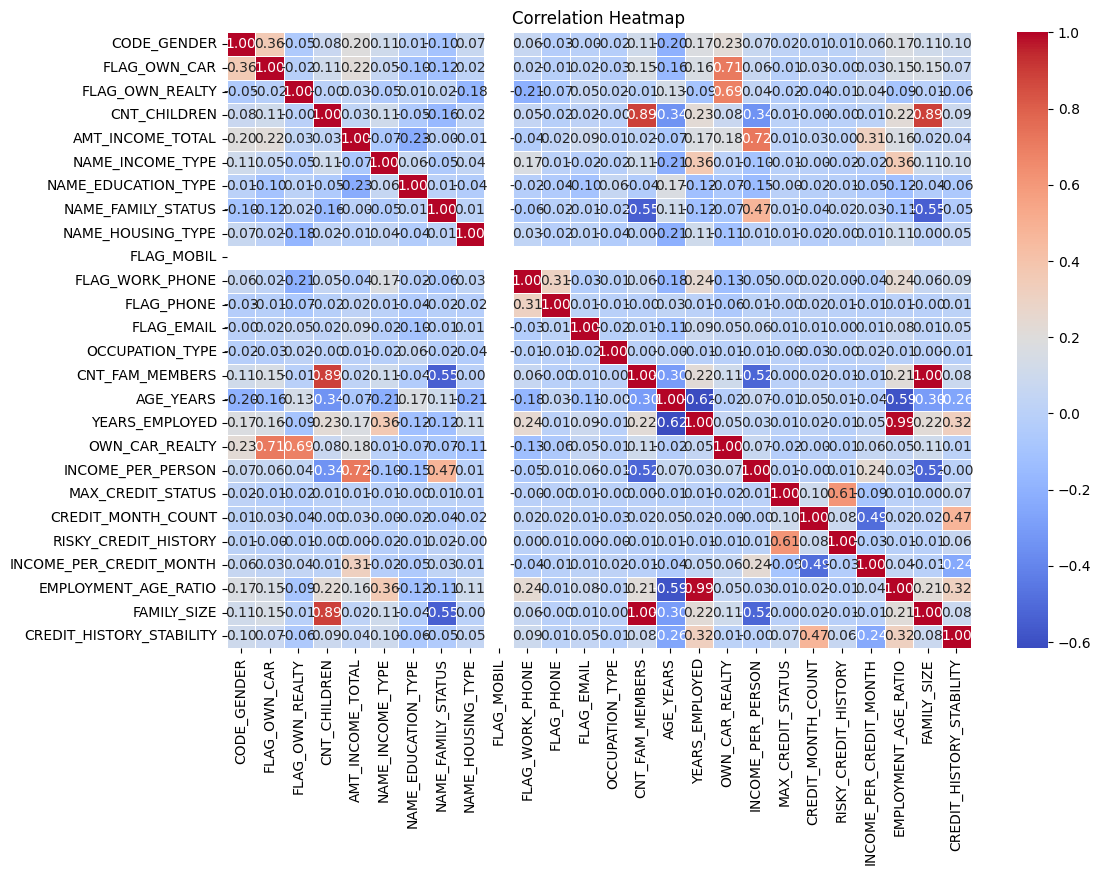

In [32]:
# Correlation heatmap to check correlations between numerical features
correlation_matrix = merged_df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

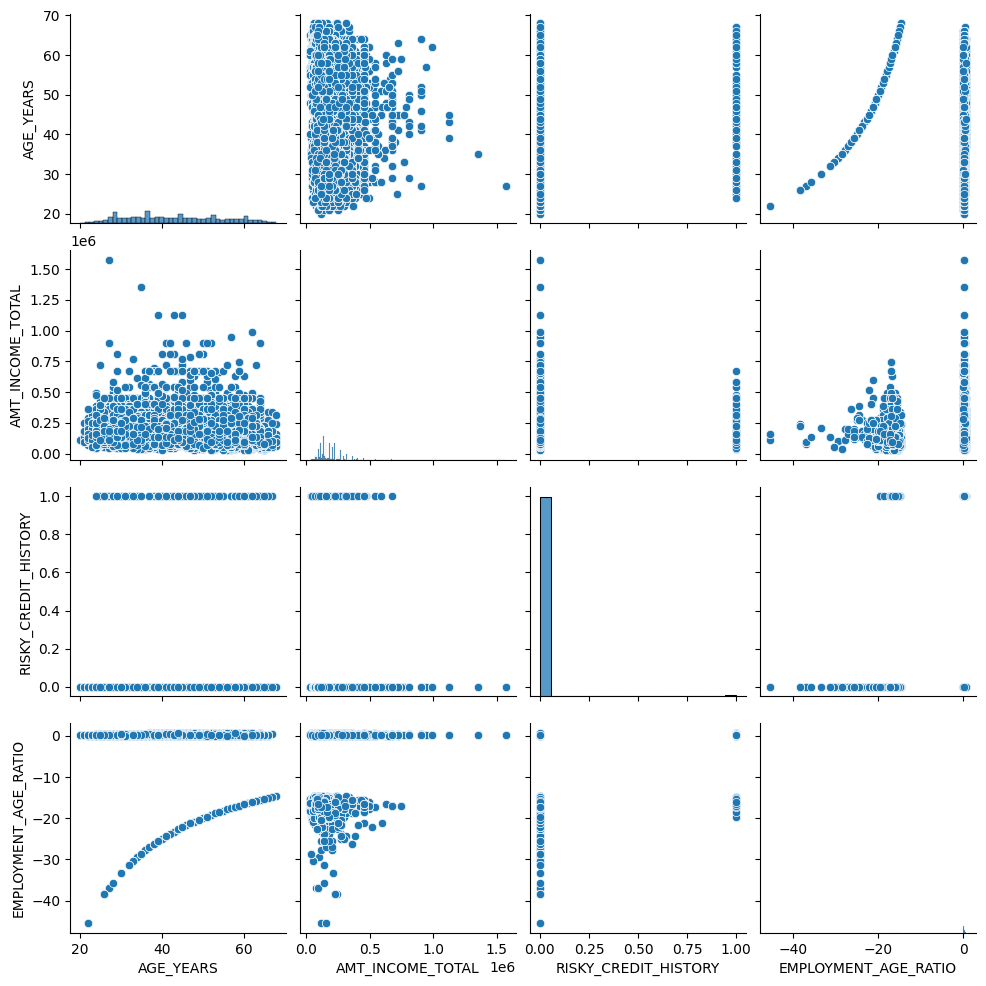

In [33]:
# Pairplot for visualizing relationships between features (optional, might be slow for large datasets)
sns.pairplot(merged_df[['AGE_YEARS', 'AMT_INCOME_TOTAL', 'RISKY_CREDIT_HISTORY', 'EMPLOYMENT_AGE_RATIO']])
plt.show()

In [35]:
# Check the columns of the merged dataframe
print(merged_df.columns)


Index(['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'FLAG_MOBIL',
       'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE',
       'CNT_FAM_MEMBERS', 'AGE_YEARS', 'YEARS_EMPLOYED', 'OWN_CAR_REALTY',
       'INCOME_PER_PERSON', 'MAX_CREDIT_STATUS', 'CREDIT_MONTH_COUNT',
       'RISKY_CREDIT_HISTORY', 'INCOME_PER_CREDIT_MONTH',
       'EMPLOYMENT_AGE_RATIO', 'FAMILY_SIZE', 'CREDIT_HISTORY_STABILITY'],
      dtype='object')


In [37]:
# Step 2: Split the Data into Features and Target Variable

# Define features and target variable
# Make sure that 'TARGET' column exists before dropping it
if 'TARGET' in merged_df.columns:
    X = merged_df.drop(['TARGET'], axis=1)  # Drop only 'TARGET' column
    y = merged_df['TARGET']  # 'TARGET' is the target variable
else:
    print("TARGET column not found. Please define a target variable.")
    # You can define 'TARGET' if it's not found, or check your dataset for the appropriate column
    # For example, assume you define it based on some condition like:
    # merged_df['TARGET'] = (merged_df['MAX_CREDIT_STATUS'] >= 3).astype(int)
    # Then, proceed with X and y splitting

# Now proceed with the model training and evaluation as shown earlier



In [40]:
# Split the Data into Features and Target Variable
# Assuming 'TARGET' is already defined, and 'ID' column has been ignored

# Split the data into features (X) and target (y)
X = merged_df.drop(['TARGET'], axis=1)  # Drop 'TARGET' column for features
y = merged_df['TARGET']  # 'TARGET' is the target variable

# Split the Data into Training and Test Sets
# Split the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)